In [3]:
# Set everything up
import os

#import cv2
#import imutils as imutils
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning
from tqdm import tqdm # make your loops show a smart progress meter 
import matplotlib.pyplot as pltch
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

RANDOM_SEED = 1
IMG_SIZE = (224, 224) # size of vgg16 input
IMG_PATH = "COVID-CT-master/Dataset/"

print(os.listdir(IMG_PATH))

['test', 'train', 'val']


In [4]:
Test_Path = IMG_PATH + "test/"
Training_Path = IMG_PATH + "train/"
Validation_Path = IMG_PATH + "val/"

In [5]:
def number_of_imgs(path):
    print(path)
    for value in os.listdir(path):
        print(value, "has", len(os.listdir(path + value)), "imgs")
    print('\n')
    
    
number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

COVID-CT-master/Dataset/test/
NonCOVID has 105 imgs
COVID has 98 imgs


COVID-CT-master/Dataset/train/
NonCOVID has 234 imgs
COVID has 191 imgs


COVID-CT-master/Dataset/val/
NonCOVID has 58 imgs
COVID has 60 imgs




In [6]:
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if hemmorhage than set if to 1 else 0
            hemmorhage = 1 if value.lower() == "COVID" else 0
            data.append({"path": file_path, 'COVID': hemmorhage})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

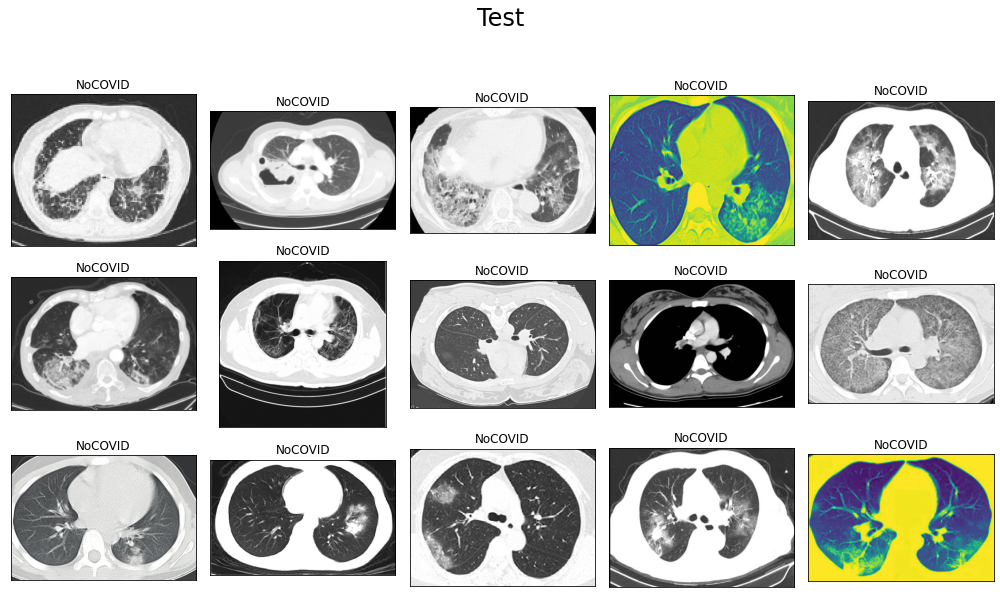

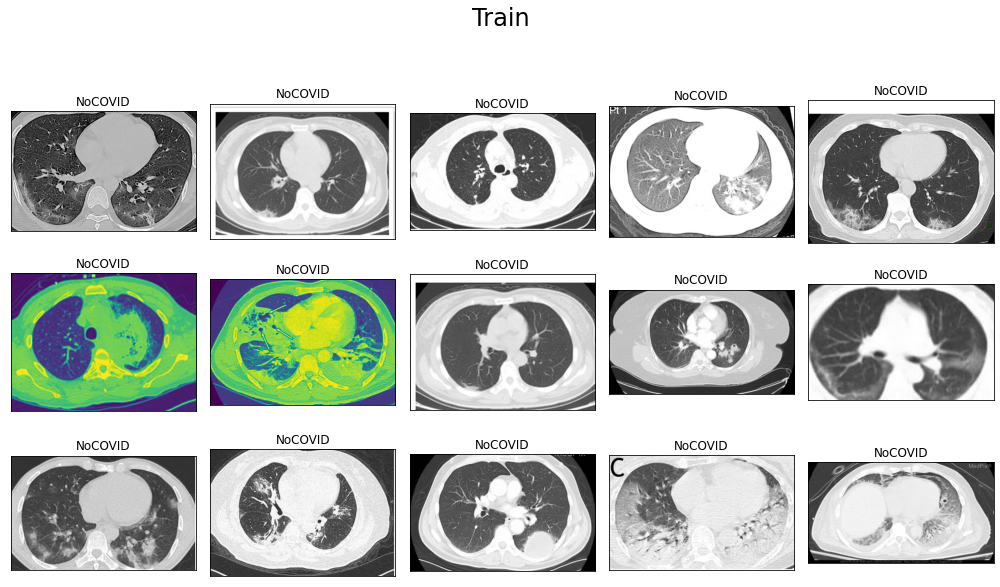

SyntaxError: not a PNG file (<string>)

<Figure size 1008x576 with 0 Axes>

In [7]:
%matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'COVID' if row['COVID'] == 1 else 'NoCOVID'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_Path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(15).reset_index(drop=True))

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    Training_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    Validation_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 425 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [ ]:
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
base_model = tf.keras.applications.VGG16(
    weights=vgg16_weight_path,
    include_top=True,
    input_shape=IMG_SIZE + (3,)
)

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 138,358,545
Trainable params: 1,001
Non-trainable params: 138,357,544
_________________________________________________________________


In [ ]:
EPOCHS = 15
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping]
)

print("Training Done")
model.save("model.h5")

Epoch 1/15
14/14 [==============================] - 119s 8s/step - loss: 0.6917 - accuracy: 0.5412
Epoch 2/15
14/14 [==============================] - 112s 8s/step - loss: 0.6909 - accuracy: 0.5435
Epoch 3/15
14/14 [==============================] - 110s 8s/step - loss: 0.6896 - accuracy: 0.5576
Epoch 4/15
14/14 [==============================] - 108s 8s/step - loss: 0.6887 - accuracy: 0.5506
Epoch 5/15
14/14 [==============================] - 110s 8s/step - loss: 0.6882 - accuracy: 0.5553
Epoch 6/15
14/14 [==============================] - 116s 8s/step - loss: 0.6883 - accuracy: 0.5482
Epoch 7/15
14/14 [==============================] - 121s 9s/step - loss: 0.6872 - accuracy: 0.5482
Epoch 8/15
14/14 [==============================] - 148s 10s/step - loss: 0.6851 - accuracy: 0.5529
Epoch 9/15
14/14 [==============================] - 138s 10s/step - loss: 0.6857 - accuracy: 0.5482
Epoch 10/15
14/14 [==============================] - 127s 10s/step - loss: 0.6841 - accuracy: 0.5506
Epoch 

In [ ]:
#Calcing the accuracy of the model
test_generator = test_datagen.flow_from_directory(
    Test_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle=False,
)  

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

Found 203 images belonging to 2 classes.
203/203 - 54s - loss: 0.6872 - accuracy: 0.5172 - 54s/epoch - 268ms/step
Test accuracy: 0.517241358757019
